In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn

In [37]:
#global variables --- same as CDC paper for small players
x_bar = 1.0   #maximum consumption
noise_var = 1.0    #variance of noise values
g = np.arange(0,1.1,0.1)  #discretization of space of power consumption values x \in [0,\bar{x}]
s_vals = np.arange(-2.0,2.0,0.1)  #discretization of space of noise values, 98% of normal distribution with unit variance
samples = np.random.normal(0, noise_var, size=100000)
s_hist = np.histogram(samples, bins=np.arange(-2.0,2.1,0.1), normed=True)[0]
s_hist = (1.0/np.linalg.norm(s_hist, ord=1)) * s_hist #probabilities over discretized noise values
ramp_const = 0.3  #time coupling ramping constraint
pi_cp_perc = 0.6  #ratio of pi_cp cost to total utility under a naive fixed strategy

net_params = {'FEATURE_DIM': 4, 'OUTPUT_DIM': 1, 'HIDDEN_1': 16}

base_path = "/home/chase/projects/peakload/notebooks/" #change this to path to notebook + data

In [38]:
def player_log_utility(x, a=1):
    #sum across multiple values or return single play value
    #a is player reward scale
    if type(x) == np.ndarray:
        return(a*np.sum(np.log(1 + x)))
    elif type(x) == torch.Tensor:
        x = np.asarray(x)
        return(a*np.sum(np.log(1 + x)))
    else:
        return(a*np.log(1 + x))
    
def cp_round(plays_array):
    #inputs is players + noise x plays array
    return(np.argmax(np.sum(plays_array, axis=0)))
           
def player_reward(player_ind, plays_array, pi_cp, a=1):
    plays = plays_array[player_ind,:]
    cp_r = cp_round(plays_array)
    reward = player_log_utility(plays, a) - pi_cp*plays[cp_r]
    return(reward)

def perturb_player(player_net, step_size=1e-1):
    out = copy.deepcopy(player_net)
    out.l1.weight.data += step_size*torch.randn(out.l1.weight.data.size())
    out.l2.weight.data += step_size*torch.randn(out.l2.weight.data.size())
    return(out)

def mutate_player(player_net):
    out = copy.deepcopy(player_net)
    out.l1.weight.data = torch.randn(out.l1.weight.data.size())
    out.l2.weight.data = torch.randn(out.l2.weight.data.size())
    return(out)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [39]:
class nnet(nn.Module):
    #a linear neural network with a sigmoid activiation function and a single hidden layer
    def __init__(self, params):
        super(nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.H1 = params['HIDDEN_1']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.H1)
        self.l2 = nn.Linear(self.H1, self.D_out)
    
    def forward(self, x):
        x = torch.sigmoid(self.l1(x)) #sigmoid activation
        x = self.l2(x) #hidden layer
        return(x)

In [75]:
#randomly initialize weights in network, perturb weights to evolve

#create two independent players
#for epoch
    #evaluate players
    #select best player, replace worst player with evolved best player
T = 2 
#pi_cp = pi_cp_perc*T*player_log_utility(x_bar)
pi_cp = 1.2
    
player_1 = nnet(net_params)
player_2 = mutate_player(player_1)

epochs = 1000000

player_1_init = 0.88
player_2_init = 0.88

best_reward = []
winner = []

for e in range(epochs):
    if e % 1000 == 0:
        print("epoch: ", e)
    plays = np.zeros((3,T))
    plays[0,0] = player_1_init #np.random.uniform(0.8,0.91)
    plays[1,0] = player_2_init #np.random.uniform(0.75,0.95)
    plays[2,0] = np.random.normal(0,noise_var)
    max_so_far = 0.0
    for t in range(1,T):
        rounds_left = float(T - t)/float(T)
        
        player_1_input = Variable(torch.Tensor([[plays[0,t-1], max_so_far, rounds_left, 1.0]]))
        player_2_input = Variable(torch.Tensor([[plays[1,t-1], max_so_far, rounds_left, 1.0]]))
        
        player_1_next = player_1(player_1_input)
        player_2_next = player_2(player_2_input)
        
        player_1_next = float(player_1_next.data)
        player_2_next = float(player_2_next.data)

        if np.abs(plays[0,t-1] - player_1_next) > ramp_const:
            if plays[0,t-1] < player_1_next:
                player_1_next = plays[0,t-1] + ramp_const
            else:
                player_1_next = plays[0,t-1] - ramp_const
                
        if player_1_next < 0.0: player_1_next = 0.0
        if player_1_next > x_bar: player_1_next = x_bar
            
        if np.abs(plays[1,t-1] - player_2_next) > ramp_const:
            if plays[1,t-1] < player_2_next:
                player_2_next = plays[1,t-1] + ramp_const
            else:
                player_2_next = plays[1,t-1] - ramp_const
                
        if player_2_next < 0.0: player_2_next = 0.0
        if player_2_next > x_bar: player_2_next = x_bar
        
        plays[0,t] = player_1_next
        plays[1,t] = player_2_next
        
        plays[2,t] = np.random.normal(0,noise_var)
        max_so_far = np.sum(plays[:,cp_round(plays)]) #close to normalized
        
    player_reward_1 = player_reward(0, plays, pi_cp)
    player_reward_2 = player_reward(1, plays, pi_cp)

    if player_reward_1 > player_reward_2:
        #keep player 1, throw out player 2
        if e % 100 == 0:
            player_2 = mutate_player(player_1)
        else:
            player_2 = perturb_player(player_1)
        best_reward.append(player_reward_1)
        winner.append(1)
    else:
        #visa versa
        if e % 100 == 0:
            player_1 = mutate_player(player_2)
        else:
            player_1 = perturb_player(player_2)
        best_reward.append(player_reward_2)
        winner.append(2)

epoch:  0
epoch:  1000
epoch:  2000
epoch:  3000
epoch:  4000
epoch:  5000
epoch:  6000
epoch:  7000
epoch:  8000
epoch:  9000
epoch:  10000
epoch:  11000
epoch:  12000
epoch:  13000
epoch:  14000
epoch:  15000
epoch:  16000
epoch:  17000
epoch:  18000
epoch:  19000
epoch:  20000
epoch:  21000
epoch:  22000
epoch:  23000
epoch:  24000
epoch:  25000
epoch:  26000
epoch:  27000
epoch:  28000
epoch:  29000
epoch:  30000
epoch:  31000
epoch:  32000
epoch:  33000
epoch:  34000
epoch:  35000
epoch:  36000
epoch:  37000
epoch:  38000
epoch:  39000
epoch:  40000
epoch:  41000
epoch:  42000
epoch:  43000
epoch:  44000
epoch:  45000
epoch:  46000
epoch:  47000
epoch:  48000
epoch:  49000
epoch:  50000
epoch:  51000
epoch:  52000
epoch:  53000
epoch:  54000
epoch:  55000
epoch:  56000
epoch:  57000
epoch:  58000
epoch:  59000
epoch:  60000
epoch:  61000
epoch:  62000
epoch:  63000
epoch:  64000
epoch:  65000
epoch:  66000
epoch:  67000
epoch:  68000
epoch:  69000
epoch:  70000
epoch:  71000
epoch

epoch:  554000
epoch:  555000
epoch:  556000
epoch:  557000
epoch:  558000
epoch:  559000
epoch:  560000
epoch:  561000
epoch:  562000
epoch:  563000
epoch:  564000
epoch:  565000
epoch:  566000
epoch:  567000
epoch:  568000
epoch:  569000
epoch:  570000
epoch:  571000
epoch:  572000
epoch:  573000
epoch:  574000
epoch:  575000
epoch:  576000
epoch:  577000
epoch:  578000
epoch:  579000
epoch:  580000
epoch:  581000
epoch:  582000
epoch:  583000
epoch:  584000
epoch:  585000
epoch:  586000
epoch:  587000
epoch:  588000
epoch:  589000
epoch:  590000
epoch:  591000
epoch:  592000
epoch:  593000
epoch:  594000
epoch:  595000
epoch:  596000


KeyboardInterrupt: 

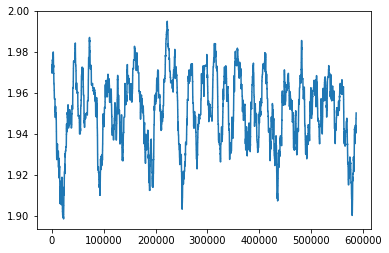

In [76]:
plt.plot(moving_average(winner, 10000))
plt.show()

In [77]:
#calculate naive optimal
nopt = 2*player_log_utility(0.88) - pi_cp*0.88
print(pi_cp)

1.2


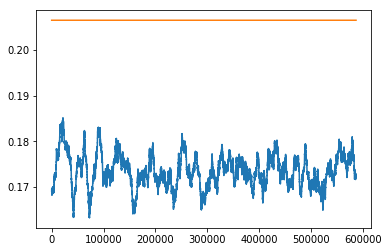

In [78]:
out = moving_average(best_reward, 10000)
plt.plot(out)
plt.plot([nopt for i in range(len(out))])
plt.show()

In [10]:
player_reward(0, plays, pi_cp)

0.36297018901463585

In [11]:
max_so_far

0.9702619188082341

In [12]:
np.mean(winner)

1.50094

In [86]:
#plot of policy for T = 2
x_curr_i = 2
x_curr = g[x_curr_i]
g_const = g[(g <= g[x_curr_i] + ramp_const) & (g >= g[x_curr_i] - ramp_const)]
T = 5

policies = []

for t in [1]:#[1,2,3,8,9]:
    net = player_1

    policy = []
    for s in 2.0*s_vals:
        inputvec = torch.Tensor(np.array([x_curr, s, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)

        play_output = net(inputvec)
        play = float(play_output.data[0,0])
        print(play)
        #snap to nearest value in range
        if play > x_bar: play = x_bar
        if play < 0.0: play = 0.0

        #snap to nearest feasible value if constraints violated
        if np.abs(x_curr - play) > ramp_const:
            if play > x_curr: play = x_curr + ramp_const
            if play < x_curr: play = x_curr - ramp_const

        policy.append(play)
    policies.append(policy)
    
del(net)

-0.289568156003952
-0.29055407643318176
-0.29168859124183655
-0.29296037554740906
-0.2943139970302582
-0.29562923312187195
-0.29669681191444397
-0.2971935570240021
-0.29666104912757874
-0.29449930787086487
-0.2899869978427887
-0.28236618638038635
-0.2710219919681549
-0.25581398606300354
-0.23758378624916077
-0.21880069375038147
-0.20410528779029846
-0.2001747190952301
-0.21398642659187317
-0.24893668293952942
-0.3004104197025299
-0.3552456200122833
-0.39783886075019836
-0.4183667004108429
-0.41590407490730286
-0.3956129848957062
-0.36439064145088196
-0.32813289761543274
-0.2908928692340851
-0.2550494968891144
-0.22177556157112122
-0.191485196352005
-0.16415050625801086
-0.13952401280403137
-0.11726740002632141
-0.0970325767993927
-0.07849958539009094
-0.06140068173408508
-0.045518189668655396
-0.030688315629959106


In [83]:
print(x_curr)

0.2


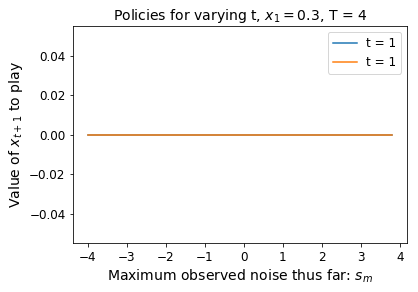

In [85]:
for t in range(1):
    plt.plot(2.0*s_vals, np.asarray(policies[t]), label="t = " + str(t+1))
plt.legend(fontsize=12)
plt.ylabel("Value of $x_{t+1}$ to play", fontsize=14)
plt.xlabel("Maximum observed noise thus far: $s_m$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Policies for varying t, $x_1 = 0.3$, T = 4", fontsize=14)
plt.show()

In [16]:
player_2.l1.weight.data

tensor([[ 0.4618, -0.5819, -0.0705, -0.3124],
        [-1.5488, -2.6585, -1.5072,  0.1234],
        [ 1.0441, -1.5921, -2.3072,  0.2707],
        [-0.0661,  1.4016,  0.3086, -1.0555]])

In [87]:
#function that determines what the optimal actions would have been
def naive_optimal_action_paths(player_index, plays):
    #2 round, ignoring initial conditions, #plus or minus the ramp constraint isn't neccessarily the optimal improvement
    #players using this leads to some sort of matching pennies type scenario
    player_array = plays[player_index,:]
    player_optimal_actions = [player_array[0], player_array[1]]
    
    cpr = cp_round(plays)
    if cpr == 1:
        opt_act = player_array[0] - ramp_const
        if opt_act < 0: opt_act = 0.0
        player_optimal_actions[1] = opt_act
    if cpr == 0:
        opt_act = player_array[0] + ramp_const
        if opt_act > 1: opt_act = 1.0
        player_optimal_actions[1] = opt_act
        
    return(player_optimal_actions)

def incremental_action_path_update(player_index, plays, inc=0.01):
    player_array = plays[player_index,:]
    player_optimal_actions = [player_array[0], player_array[1]]
    
    cpr = cp_round(plays)
    
    if cpr == 1:
        opt_act = player_array[0] - inc*ramp_const
        if opt_act < 0: opt_act = 0.0
        player_optimal_actions[1] = opt_act
    if cpr == 0:
        opt_act = player_array[0] + inc*ramp_const
        if opt_act > 1: opt_act = 1.0
        player_optimal_actions[1] = opt_act
        
    return(player_optimal_actions)


In [91]:
#try value function that incorporates a player's prediction of what they think the system will look like on the next round
#the policy return is not differentiable with respect to the policy weights because of CP discontinuities but do it anyway
#if that doesn't work add a log barrier to the rank ordered rounds so that the return *is* differentiable with respect to the weights allowing
#us to drop the argmax term

#two round, two player game
#deterministic NN policy
#target values should be maximum utility mod CP cost

#this is without incorporating predictions of what the other agents are going to do

pi_cp_perc = 0.6
MC_N = 30000
batch = 100
T = 2
#pi_cp = pi_cp_perc*T*player_log_utility(x_bar)
pi_cp = 1.2

player_1 = nnet(net_params)
player_2 = mutate_player(player_1)

player_1_init = 0.8
player_2_init = 0.8

player_1_path = []
player_2_path = []

player_1_training_pairs = []
player_2_training_pairs = []

player_1_returns = []
player_2_returns = []

batch_system_samps = []
player_1_samps = []
player_2_samps = []

#may need to do policy gradient steps batched
loss_player_1 = nn.MSELoss()
loss_player_2 = nn.MSELoss()
optimizer_1 = optim.SGD(player_1.parameters(),lr=0.005, momentum=0.9)
optimizer_2 = optim.SGD(player_2.parameters(),lr=0.005, momentum=0.9)

for mc in range(MC_N):
    if mc % 1000 == 0:
        print("epoch: ", mc)
    plays = np.zeros((3,T))
    plays[0,0] = player_1_init
    plays[1,0] = player_2_init
    plays[2,0] = np.random.normal(0,noise_var)
    max_so_far = 0.0
    #play the game
    for t in range(1,T):
        rounds_left = float(T - t)/float(T)
        #for player in players:
            #vectorize input
        player_1_input = Variable(torch.Tensor([[plays[0,t-1], max_so_far, rounds_left, 1.0]]))
        player_2_input = Variable(torch.Tensor([[plays[1,t-1], max_so_far, rounds_left, 1.0]]))

        #get next action
        player_1_next_tens = player_1(player_1_input)
        player_2_next_tens = player_2(player_2_input)

        #squeeze next action inside bounds
        player_1_next = float(player_1_next_tens.data)
        player_2_next = float(player_2_next_tens.data)

        if np.abs(plays[0,t-1] - player_1_next) > ramp_const:
            if plays[0,t-1] < player_1_next:
                player_1_next = plays[0,t-1] + ramp_const
            else:
                player_1_next = plays[0,t-1] - ramp_const

        if player_1_next < 0.0: player_1_next = 0.0
        if player_1_next > x_bar: player_1_next = x_bar

        if np.abs(plays[1,t-1] - player_2_next) > ramp_const:
            if plays[1,t-1] < player_2_next:
                player_2_next = plays[1,t-1] + ramp_const
            else:
                player_2_next = plays[1,t-1] - ramp_const

        if player_2_next < 0.0: player_2_next = 0.0
        if player_2_next > x_bar: player_2_next = x_bar

        plays[0,t] = player_1_next
        plays[1,t] = player_2_next
            
        s_t = np.random.normal(0, noise_var)
        plays[2,t] = s_t
        
        max_so_far = np.max(plays[2,:])
        
        batch_system_samps.append([np.sum(plays[:,0]), np.sum(plays[:,1])])
        player_1_samps.append([np.sum(plays[:,0]), plays[0,1]])
        player_2_samps.append([np.sum(plays[:,0]), plays[1,1]])
        
        player_1_path.append((np.asarray(player_1_input), player_1_next))
        player_2_path.append((np.asarray(player_2_input), player_2_next))
        
        player_1_returns.append(player_reward(0, plays, pi_cp))
        player_2_returns.append(player_reward(1, plays, pi_cp))
        
        
    #policy gradient step
    #for player in players:
    
    """
    opt_action_player_1 = naive_optimal_action_paths(0, plays)[1]
    opt_action_player_2 = naive_optimal_action_paths(1, plays)[1] #will it even converge to playing maximum
    """
    
    opt_action_player_1 = incremental_action_path_update(0, plays, inc=0.001)[1]
    opt_action_player_2 = incremental_action_path_update(1, plays, inc=0.001)[1]
        
    player_1_training_pairs.append((player_1_next_tens, opt_action_player_1))
    player_2_training_pairs.append((player_2_next_tens, opt_action_player_2))
    
    if mc % batch == 0:

        outputs_1 = []
        labels_1 = []
        for p in player_1_training_pairs:
            outputs_1.append(p[0])
            labels_1.append(torch.Tensor([[p[1]]]))
        outputs_1 = torch.cat(outputs_1)
        labels_1 = Variable(torch.cat(labels_1))
        
        outputs_2 = []
        labels_2 = []
        for p in player_2_training_pairs:
            outputs_2.append(p[0])
            labels_2.append(torch.Tensor([[p[1]]]))
        outputs_2 = torch.cat(outputs_2)
        labels_2 = Variable(torch.cat(labels_2))
        
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()

        loss_p1_value = loss_player_1(outputs_1, labels_1)#player_1_next_tens, torch.Tensor([[opt_action_player_1]]))
        loss_p2_value = loss_player_2(outputs_2, labels_2)#player_2_next_tens, torch.Tensor([[opt_action_player_2]]))

        loss_p1_value.backward(retain_graph=True)
        loss_p2_value.backward(retain_graph=True)

        optimizer_1.step()
        optimizer_2.step()
        
        batch_system_samps = []
        player_1_samps = []
        player_2_samps = []

epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000
epoch:  30000


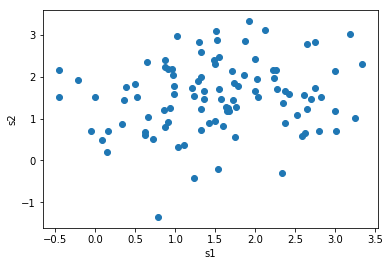

In [92]:
bs = np.asarray(batch_system_samps)
bs.shape

plt.scatter(bs[:,0], bs[:,1])
plt.xlabel("s1")
plt.ylabel("s2")
plt.show()

(99, 2)


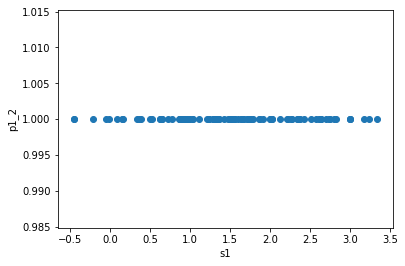

In [93]:
bs = np.asarray(player_1_samps)
print(bs.shape)

plt.scatter(bs[:,0], bs[:,1])
plt.xlabel("s1")
plt.ylabel("p1_2")
plt.show()

(99, 2)


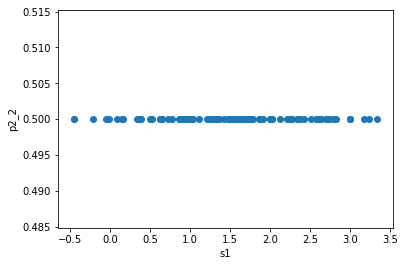

In [94]:
bs = np.asarray(player_2_samps)
print(bs.shape)

plt.scatter(bs[:,0], bs[:,1])
plt.xlabel("s1")
plt.ylabel("p2_2")
plt.show()

In [95]:
#plot the strategies
#not working for the 2 round case because max_so_far is the max noise not the max system value
player_1_input = Variable(torch.Tensor([[plays[0,t-1], max_so_far, rounds_left, 1.0]]))
player_2_input = Variable(torch.Tensor([[plays[1,t-1], max_so_far, rounds_left, 1.0]]))

player_1_next_tens = player_1(player_1_input)
player_2_next_tens = player_2(player_2_input)

In [96]:
print(np.mean(player_1_returns))
print(np.mean(player_2_returns))

0.18890002064230624
0.18868406009978664


In [ ]:
nopt = 2*player_log_utility(0.88) - pi_cp*0.88
print(pi_cp)

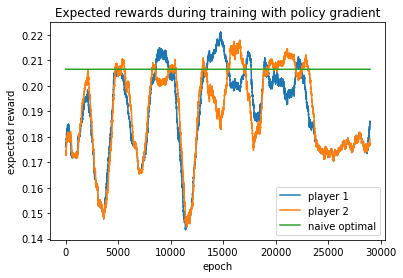

In [109]:
#plt.plot(player_1_returns)
plt.plot(moving_average(player_2_returns, 1000), label="player 1")
plt.plot(moving_average(player_1_returns, 1000), label="player 2")
plt.plot([nopt for i in range(len(moving_average(player_1_returns, 1000)))], label="naive optimal")
plt.title("Expected rewards during training with policy gradient")
plt.xlabel("epoch")
plt.ylabel("expected reward")
plt.legend()
plt.show()

#look at the mean of players' rewards per round

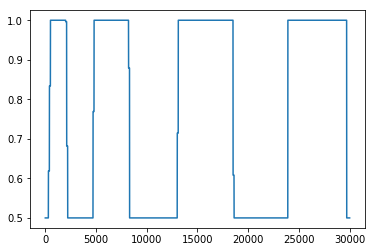

In [103]:
actions = []
for p in player_2_path:
    actions.append(p[1])
    
plt.plot(actions)
plt.show()

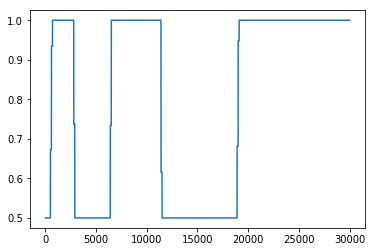

In [104]:
actions = []
for p in player_1_path:
    actions.append(p[1])
    
plt.plot(actions)
plt.show()

### Naive update full ramp_const increment

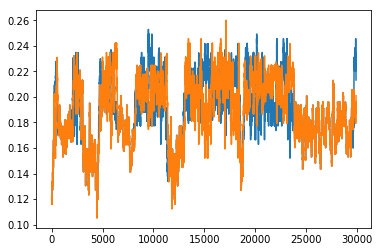

In [106]:
#plt.plot(player_1_returns)
plt.plot(moving_average(player_2_returns, 100))
plt.plot(moving_average(player_1_returns, 100))
plt.show()

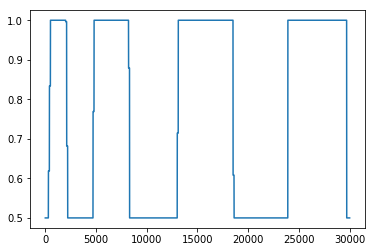

In [107]:
actions = []
for p in player_2_path:
    actions.append(p[1])
    
plt.plot(actions)
plt.show()

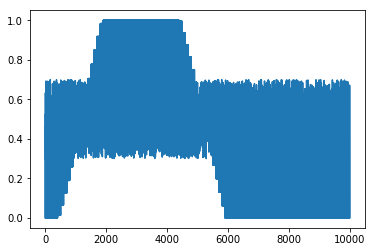

In [28]:
actions = []
for p in player_1_path:
    actions.append(p[1])
    
plt.plot(actions)
plt.show()

In [32]:
optimal_action_paths(0,plays)

[0.09949293172920903, 0.0]

In [35]:
#like the above
#we need each player to have some sort of predictor of what the other player is going to do

#have to player keep a ledger of what the players did on previous turns
#have some sort of function that maps the previous sum to the next output
#predict the player doing a noisy sample of what the player did in a similar situation previously